## Cargamos todas las librerias necesarias

In [12]:
import empyrical as ep
import pandas as pd 
import datetime
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import sys, os
import warnings

%matplotlib inline
mpl.rcParams['figure.dpi']= 300
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style("whitegrid")
sns.set_palette("Paired")
pylab.rcParams['figure.figsize'] = 16, 6
warnings.filterwarnings("ignore")


## Parte 1. ¿Darwins Buenos?

¿Realmente buenos?
Retornos pasados NO garantizan retornos futuros, pero si que se puede hacer "arqueologia" sobre lo que hicieron,
Consideramos que cada punto de variacion del darwin es 1 dolar, por simplificar

In [2]:
portfolio = {

    "guenos/SYO.CSV":1, # ruta/ficherodarwin.csv : nivel de apalancamiento del mismo.
    "guenos/THA.csv":1,
    "guenos/ZVQ.csv":1,
    "guenos/LVS.csv":1
}


## Creamos un dataframe con todos los darwins, y ademas los sumamos para poder meterles mano

In [3]:
df_sessionlogs = {}

for informe_path in portfolio:
    multiplicador = portfolio[informe_path]
    df = pd.read_csv(informe_path,parse_dates=True,index_col=['Date'])
    df["Price"] = df["Price"] * multiplicador
    df_sessionlogs[informe_path] = df

In [4]:
df_portfolio = None

for informe_path in df_sessionlogs:
    if df_portfolio is None:
        df_portfolio = df_sessionlogs[informe_path]
        df_portfolio.columns = [informe_path]
    else:
        df_portfolio = df_portfolio.join(df_sessionlogs[informe_path].rename(columns={
            "Price":informe_path
        })).fillna(0)
        
# Creamos la columna total con el PyG del portfolio
df_portfolio["total"] = df_portfolio.sum(axis=1)

## Ahora vamos a calcular el capital minimo con el que entrar en el portfolio, No es la forma optima , pero si una aproximacion

In [5]:
# Calculamos la peor sesion
peor_sesion = df_portfolio["total"].min()

# Calculamos el peor DD
cumulative = df_portfolio["total"].cumsum().values
max_return = np.fmax.accumulate(cumulative)
peor_drawdown = np.nanmin(cumulative - max_return)

# Utilizamos una formula "inventada" para llegar a un capital minimo aceptable. 
capital_sugerido = abs(round(min(5*peor_drawdown,15*peor_sesion),0))

# Creamos el DF con la informacion necesaria, y lo mostramos
df_estadisticas = pd.DataFrame.from_dict({
    "Peor Sesion": peor_sesion,
    "Peor Drawdown": peor_drawdown,
    "Capital Necesario": capital_sugerido
},"index")

df_estadisticas.columns = ["Darwins Buenos"]

## Comprobamos que los DDs existen, y debemos controlarlos si no queremos ser fulminados por el mercado

In [6]:
df_estadisticas

,Darwins Buenos
Peor Sesion,-45.570
Peor Drawdown,-117.900
Capital Necesario,684.000


## Calculamos los retornos del portfolio y el resto de estadisticas para poder analizarlo

In [7]:
df_returns = (df_portfolio["total"].cumsum() + capital_sugerido).pct_change().dropna() # retornos en $ + capital sugerido

In [8]:
df_performance = pd.DataFrame.from_dict({
    "PyG": df_portfolio["total"].cumsum().values[-1],
    "Sesiones Analizadas": len(df_portfolio),
    "Sesiones Ganadoras (%)": 100 * len(df_portfolio[df_portfolio["total"]>0]) /  len(df_portfolio[df_portfolio["total"]!=0]),
    "ROI Anualizado": 100 * ep.annual_return(df_returns),
    "CAGR" :  100 * ep.cagr(df_returns),
    "Volatilidad Anualizada": 100 *  ep.annual_volatility(df_returns),
    "Profit Factor":  df_returns[df_returns > 0].sum() / abs(df_returns[df_returns < 0].sum()),
    "Promedio Sesion Ganadora":  df_portfolio[df_portfolio["total"] > 0]["total"].mean(),
    "Promedio Sesion Perdedora":  df_portfolio[df_portfolio["total"] < 0]["total"].mean(),
    "Ratio Sharpe": ep.sharpe_ratio(df_returns),
    "Ratio Sortino": ep.sortino_ratio(df_returns),
    "Ratio Calmar" :  ep.calmar_ratio(df_returns),
    "Tail Ratio" : ep.tail_ratio(df_returns),
    "Omega Ratio" : ep.omega_ratio(df_returns),
    "Peor Sesion": peor_sesion,
    "Peor Drawdown": peor_drawdown,
    "Min Bankroll NoBust": capital_sugerido,
    "VAR95%" : ep.value_at_risk(df_returns,0.95),
},"index")

df_performance.columns = ["Portfolio Bueno"]

In [9]:
df_performance

,Portfolio Bueno
PyG,1335.560
Sesiones Analizadas,685.000
Sesiones Ganadoras (%),57.810
ROI Anualizado,49.201
CAGR,49.201
Volatilidad Anualizada,14.493
Profit Factor,1.695
Promedio Sesion Ganadora,9.071
Promedio Sesion Perdedora,-7.809
Ratio Sharpe,2.835


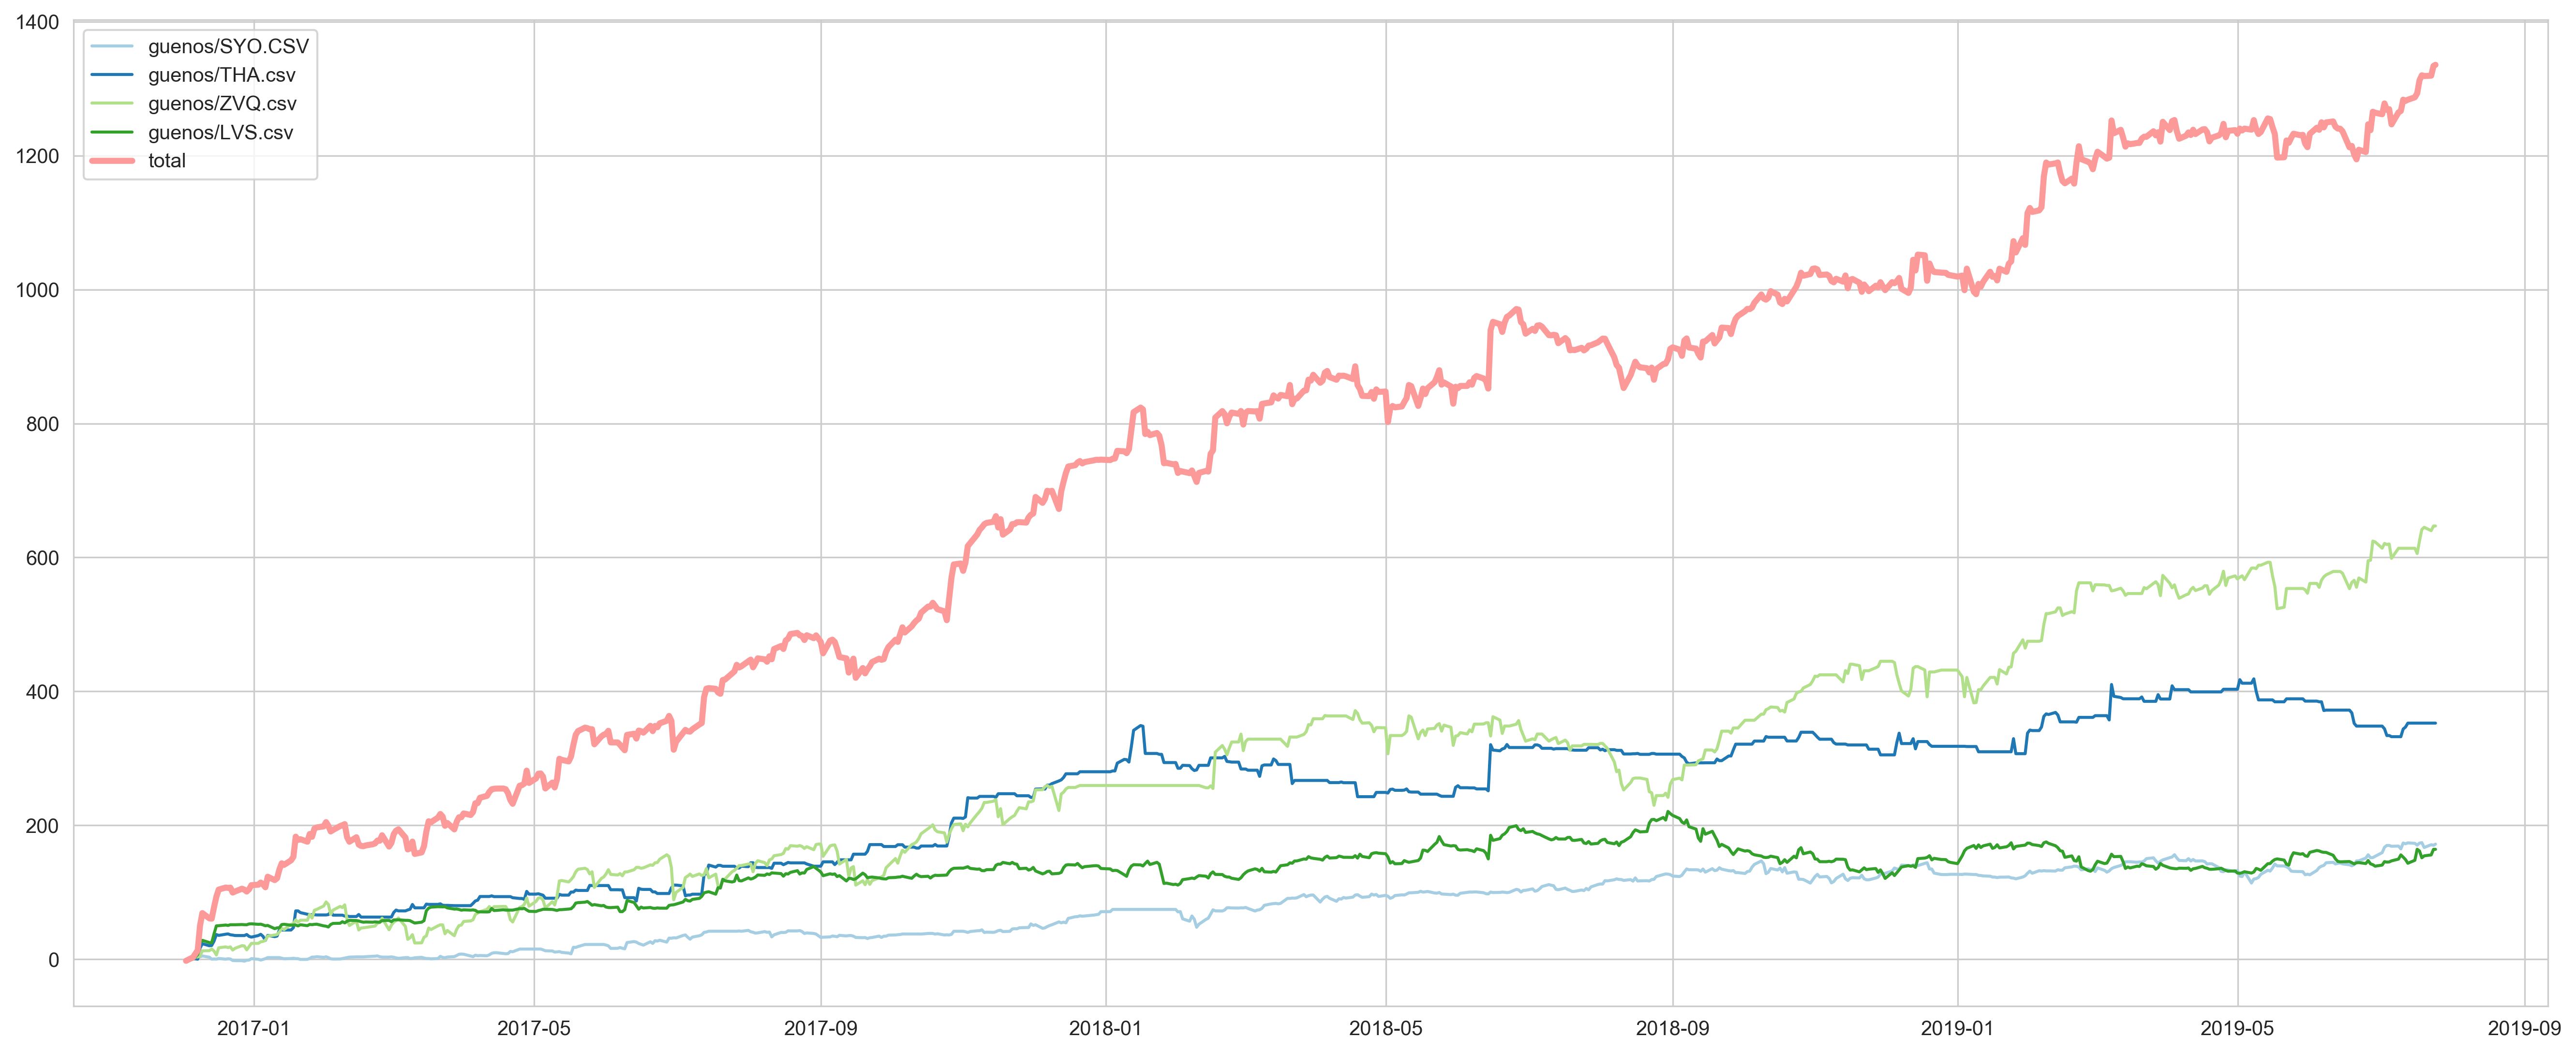

In [13]:
fig = plt.figure(figsize=(22,9))

plt.plot(df_portfolio.drop("total", axis=1).cumsum())
plt.plot(df_portfolio["total"].cumsum(), linewidth=3);

leg = plt.legend(df_portfolio.columns.values)
plt.show()